In [43]:
import os

import pandas as pd
import geopandas as gpd
from pandas.io.json import json_normalize
import json

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
%matplotlib inline

In [2]:
data_path = os.getenv('DATA_PATH')

In [3]:
data = []
with open(data_path + '/tweets_2019-03-25.json') as f:
    for line in f:
        data.append(json.loads(line))

df = json_normalize(data)

In [4]:
df.head()

,borough,contributors,coordinates.coordinates,coordinates.type,coords_source,created_at,display_text_range,entities.hashtags,entities.media,entities.symbols,...,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified
0,Brooklyn,None,"[-74.02246922567996, 40.6458190323863]",Point,Randomized,Mon Mar 25 00:00:05 -0400 2019,"[15, 16]",[],NaN,[],...,333333,True,False,RallyBeagle,235,None,none,None,None,False
1,Bronx,None,"[-73.87304447466002, 40.85190672099046]",Point,Randomized,Mon Mar 25 00:00:07 -0400 2019,NaN,[],NaN,[],...,333333,True,False,Jgardnernorth1,2970,None,none,None,None,False
2,Brooklyn,None,"[-73.90293203829336, 40.61399639052241]",Point,Randomized,Mon Mar 25 00:00:08 -0400 2019,NaN,[],NaN,[],...,000000,True,False,conleyfanclub,448340,None,none,https://soundcloud.com/conley-p,None,False
3,Manhattan,None,"[-73.92998973319666, 40.8486461240987]",Point,Randomized,Mon Mar 25 00:00:10 -0400 2019,NaN,[],NaN,[],...,333333,True,False,xjoshjohnson,9316,None,none,None,None,False
4,Brooklyn,None,"[-73.93387182930736, 40.6762074033064]",Point,Randomized,Mon Mar 25 00:00:11 -0400 2019,"[15, 54]",[],NaN,[],...,000000,False,False,dancesiobhan,761,None,none,None,None,False


In [5]:
list(df.columns)

['borough',
 'contributors',
 'coordinates.coordinates',
 'coordinates.type',
 'coords_source',
 'created_at',
 'display_text_range',
 'entities.hashtags',
 'entities.media',
 'entities.symbols',
 'entities.urls',
 'entities.user_mentions',
 'extended_entities.media',
 'extended_tweet.display_text_range',
 'extended_tweet.entities.hashtags',
 'extended_tweet.entities.media',
 'extended_tweet.entities.symbols',
 'extended_tweet.entities.urls',
 'extended_tweet.entities.user_mentions',
 'extended_tweet.extended_entities.media',
 'extended_tweet.full_text',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'geo.coordinates',
 'geo.type',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'place.bounding_box.coordinates',
 'place.bounding_box.type',
 'place.country',
 'place.country_code',
 'place.full_name',
 'place.id',
 'place.name',
 'p

In [22]:
df.shape

(40644, 194)

In [7]:
boro_pct = df.borough.value_counts()/df.borough.value_counts().sum()*100
boro_pct

Manhattan        49.510383
Brooklyn         26.003838
Queens           18.713709
Bronx             3.498671
Staten Island     2.273398
Name: borough, dtype: float64

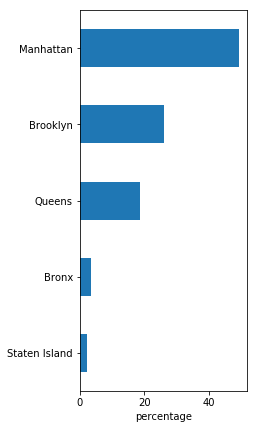

In [74]:
fig, ax = plt.subplots(figsize=(3,7))

boro_pct.sort_values().plot.barh(ax=ax, color='tab:blue')
ax.set_xlabel('percentage')
plt.show()

In [26]:
df.coords_source.value_counts()

Randomized    34375
Origin         6269
Name: coords_source, dtype: int64

In [40]:
randomization = (df.coords_source.apply(lambda x: x + ' (') + df['place.place_type'].apply(lambda x: str(x) + ')')).apply(
    lambda x: x.replace('city', 'borough').replace('admin', 'city') if x.startswith('Randomized') else 'Origin').value_counts().pipe(
    lambda x: x/x.sum()).sort_index()
randomization

Origin                       0.154242
Randomized (borough)         0.708592
Randomized (city)            0.110988
Randomized (neighborhood)    0.010506
Randomized (poi)             0.015673
dtype: float64

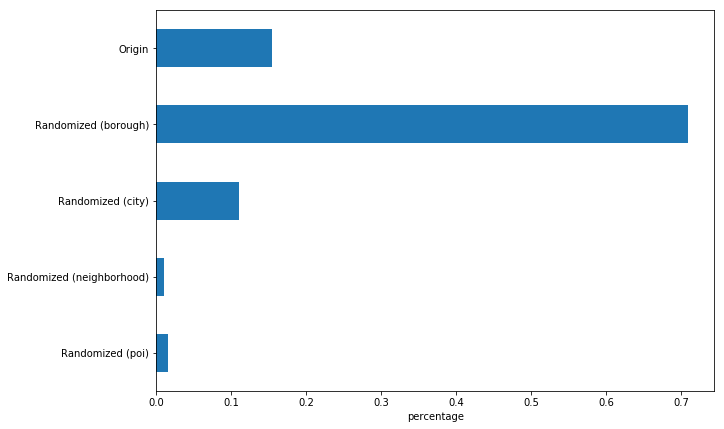

In [46]:
fig, ax = plt.subplots(figsize=(10,7))

randomization[::-1].plot.barh(ax=ax, color='tab:blue')
ax.set_xlabel('percentage')
plt.show()

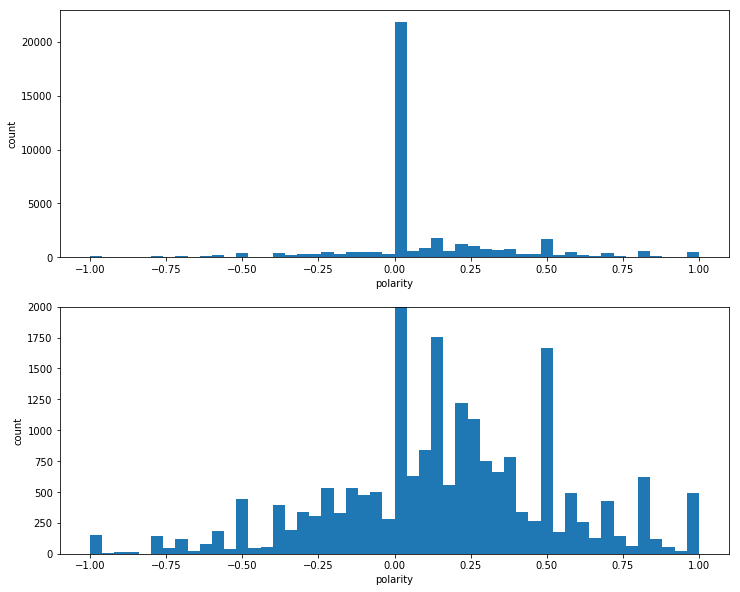

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,10))

df.polarity.hist(bins=50, ax=ax1)
ax1.set_xlabel('polarity')
ax1.set_ylabel('count')
ax1.grid(False)

df.polarity.hist(bins=50, ax=ax2)
ax2.set_xlabel('polarity')
ax2.set_ylabel('count')
ax2.grid(False)
ax2.set_ylim(0,2000)

plt.show()

In [62]:
(df.polarity > 0).sum()/len(df)

0.34179706721779352

In [63]:
(df.polarity < 0).sum()/len(df)

0.12907194173801792

In [66]:
(df.polarity == 0).sum()/len(df)

0.52913099104418859

In [69]:
df.polarity.isna().sum()

0

In [10]:
from functools import reduce

def reducer(x,y):
    y = y.lower()
    x[y] = x.get(y,0) + 1
    return x

def get_entity(ent, sub, prefix):

    entity = list(map(lambda x: list(map(lambda y: prefix+y[sub], x)) if len(x) > 0 else None,df['entities.{}'.format(ent)]))

    entity = [item for sublist in entity if sublist is not None for item in sublist]

    entity = reduce(reducer, entity, {})

    entity = list(zip(entity.keys(), entity.values()))

    entity.sort(key=lambda x: x[1], reverse=True)
    
    return entity

In [11]:
hashtags = get_entity('hashtags', 'text', '#')
hashtags[:10]

[('#newyork', 249),
 ('#nyc', 232),
 ('#tshirt', 136),
 ('#tshirts', 136),
 ('#tshirtdesign', 136),
 ('#appleevent', 126),
 ('#freeship', 84),
 ('#newyorkcity', 73),
 ('#brooklyn', 73),
 ('#lhhatl', 72)]

In [12]:
len(hashtags)

6723

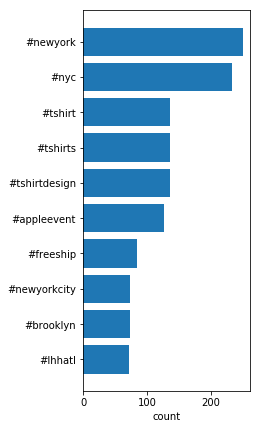

In [59]:
fig, ax = plt.subplots(figsize=(3,7))

x, y = zip(*hashtags[:10])

ax.barh(x[::-1], y[::-1], color='tab:blue')
ax.set_xlabel('count')
plt.show()

In [14]:
user_mentions = get_entity('user_mentions', 'screen_name', '@')
user_mentions[:10]

[('@realdonaldtrump', 339),
 ('@amazon', 146),
 ('@cnn', 84),
 ('@donaldjtrumpjr', 73),
 ('@jackposobiec', 73),
 ('@ilhanmn', 67),
 ('@apple', 67),
 ('@senatemajldr', 66),
 ('@senschumer', 65),
 ('@sugardaddysnyc', 57)]

In [15]:
len(user_mentions)

16912

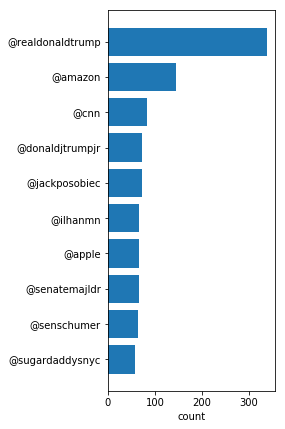

In [58]:
fig, ax = plt.subplots(figsize=(3,7))

x, y = zip(*user_mentions[:10])

ax.barh(x[::-1], y[::-1], color='tab:blue')
ax.set_xlabel('count')
plt.show()

In [17]:
df.created_at = df.created_at.apply(datetime.strptime, args=('%a %b %d %H:%M:%S %z %Y',))
df.set_index('created_at', inplace=True)
df.head()

,borough,contributors,coordinates.coordinates,coordinates.type,coords_source,display_text_range,entities.hashtags,entities.media,entities.symbols,entities.urls,...,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified
created_at,,,,,,,,,,,,,,,,,,,,,
2019-03-25 00:00:05-04:00,Brooklyn,None,"[-74.02246922567996, 40.6458190323863]",Point,Randomized,"[15, 16]",[],NaN,[],[],...,333333,True,False,RallyBeagle,235,None,none,None,None,False
2019-03-25 00:00:07-04:00,Bronx,None,"[-73.87304447466002, 40.85190672099046]",Point,Randomized,NaN,[],NaN,[],[],...,333333,True,False,Jgardnernorth1,2970,None,none,None,None,False
2019-03-25 00:00:08-04:00,Brooklyn,None,"[-73.90293203829336, 40.61399639052241]",Point,Randomized,NaN,[],NaN,[],"[{'url': 'https://t.co/ZaTH2kNedv', 'expanded_...",...,000000,True,False,conleyfanclub,448340,None,none,https://soundcloud.com/conley-p,None,False
2019-03-25 00:00:10-04:00,Manhattan,None,"[-73.92998973319666, 40.8486461240987]",Point,Randomized,NaN,[],NaN,[],[],...,333333,True,False,xjoshjohnson,9316,None,none,None,None,False
2019-03-25 00:00:11-04:00,Brooklyn,None,"[-73.93387182930736, 40.6762074033064]",Point,Randomized,"[15, 54]",[],NaN,[],[],...,000000,False,False,dancesiobhan,761,None,none,None,None,False


In [18]:
frequency = df.resample('20Min')['borough'].count()

In [19]:
frequency.loc[(frequency.index > '2019-03-25 09:00:00') & (frequency.values < 300)] = None

In [20]:
frequency.interpolate(inplace=True)

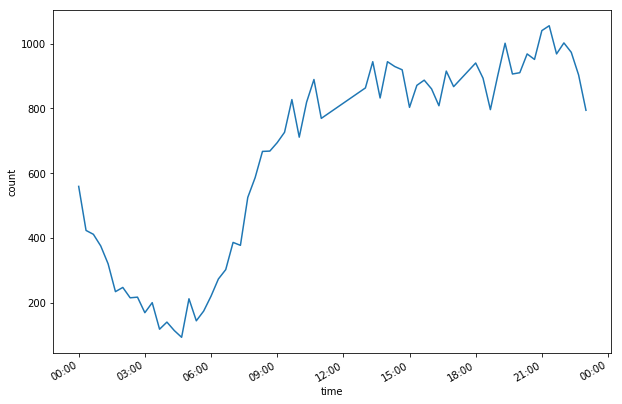

In [21]:
fig, ax = plt.subplots(figsize=(10,7))

frequency.plot(ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('count')

myFmt = DateFormatter("%H:%M", tz=frequency.index.tz)
ax.xaxis.set_major_formatter(myFmt)

plt.show()